# **Analyzing the gradient leakage problem on a variety of vehicles**

In [1]:
import json

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

/home/madbiker/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
RESULTS_ROOT = "./04_distr_gradient_leakage/results/"

## **1. Statistical evaluation**

### 1.1 Averages

In [28]:
#reading the data:
vehicle_data = {}
for i in range(5):
    with open(RESULTS_ROOT+f"vehicle_results_{i}.json") as f:
        data = json.load(f)
        
    for veh in data:
        
        if veh.startswith("h"):
            veh_type = "household"
        elif veh.startswith("c"):
            veh_type = "commute"
        elif veh.startswith("r"):
            veh_type = "random"
            
        #if i == 0:
        if not(veh in vehicle_data):
            vehicle_data[veh] = {
                "position_rate": len(data[veh]["positions"]),
                "time_offset": np.abs(data[veh]["time_offset"]),
                "type": veh_type,
                "occurence": 1
            }
        else:
            vehicle_data[veh]["position_rate"] += len(data[veh]["positions"])
            vehicle_data[veh]["time_offset"] += np.abs(data[veh]["time_offset"])
            vehicle_data[veh]["occurence"] += 1
            
gl_df = pd.DataFrame.from_dict(vehicle_data, orient="index")
gl_df["position_rate"] = gl_df["position_rate"]/gl_df["occurence"]
gl_df["time_offset"] = gl_df["time_offset"]/gl_df["occurence"]

In [29]:
gl_df

,position_rate,time_offset,type,occurence
carIn343,6.0,0.0,commute,1
randUni277:6,9.0,27.0,random,1
randUni94:4,3.5,20.0,random,2
randUni417:6,5.5,23.5,random,2
randUni860:4,7.0,2.0,random,1
...,...,...,...,...
h620c1:0,3.0,21.0,household,1
h3077c1:0,9.0,0.0,household,1
randUni394:7,4.0,17.0,random,1
h3193c1:0,8.0,1.0,household,1


array([[<AxesSubplot: title={'center': 'position_rate'}>,
        <AxesSubplot: title={'center': 'time_offset'}>],
       [<AxesSubplot: title={'center': 'occurence'}>, <AxesSubplot: >]],
      dtype=object)

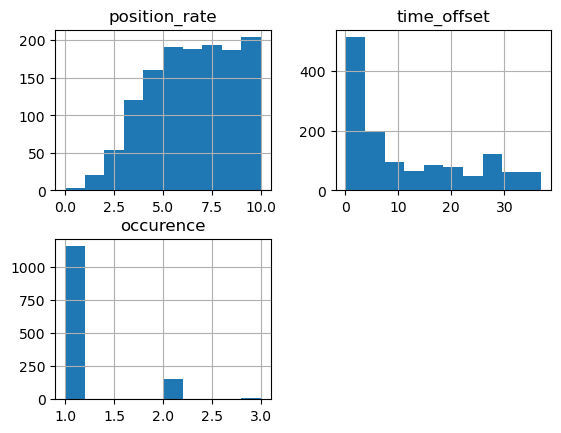

In [30]:
gl_df.hist()

In [31]:
gl_df.groupby("type").mean()

,position_rate,time_offset,occurence
type,,,
commute,5.982206,1.825623,1.085409
household,7.409924,6.264833,1.148867
random,5.517030,16.777475,1.144414


In [32]:
gl_df.groupby("type").std()

,position_rate,time_offset,occurence
type,,,
commute,2.017257,2.209117,0.279988
household,2.071302,9.393431,0.382881
random,2.149796,10.737366,0.377924


### 1.2 Extremal cases

In [33]:
gl_df["abs_time_offset"] = np.abs(gl_df["time_offset"])

In [34]:
gl_df[gl_df["position_rate"] == max(gl_df["position_rate"])]

,position_rate,time_offset,type,occurence,abs_time_offset
h3055c1:0,10.0,0.0,household,1,0.0
h920c1:0,10.0,0.0,household,1,0.0
h197c1:0,10.0,4.0,household,1,4.0
h3037c2:0,10.0,4.0,household,1,4.0
h2548c1:0,10.0,7.5,household,2,7.5
...,...,...,...,...,...
h3460c1:0,10.0,3.0,household,1,3.0
randUni18:4,10.0,26.0,random,1,26.0
carIn179,10.0,0.0,commute,1,0.0
randUni620:8,10.0,34.0,random,1,34.0


In [35]:
gl_df[gl_df["position_rate"] == min(gl_df["position_rate"])]

,position_rate,time_offset,type,occurence,abs_time_offset
randUni401:5,0.0,34.0,random,1,34.0
randUni812:4,0.0,5.0,random,1,5.0


In [36]:
gl_df[gl_df["abs_time_offset"] == max(gl_df["abs_time_offset"])]

,position_rate,time_offset,type,occurence,abs_time_offset
h1751c1:0,7.0,37.0,household,1,37.0


In [37]:
gl_df[gl_df["abs_time_offset"] == min(gl_df["abs_time_offset"])]

,position_rate,time_offset,type,occurence,abs_time_offset
carIn343,6.0,0.0,commute,1,0.0
carIn386,5.0,0.0,commute,1,0.0
h3055c1:0,10.0,0.0,household,1,0.0
h920c1:0,10.0,0.0,household,1,0.0
carIn744,5.0,0.0,commute,1,0.0
...,...,...,...,...,...
carIn616,8.0,0.0,commute,1,0.0
carIn569,3.0,0.0,commute,1,0.0
carIn715,7.0,0.0,commute,1,0.0
h3077c1:0,9.0,0.0,household,1,0.0


### 1.3 Distributions by vehicle type

Text(0, 0.5, 'matched parkings')

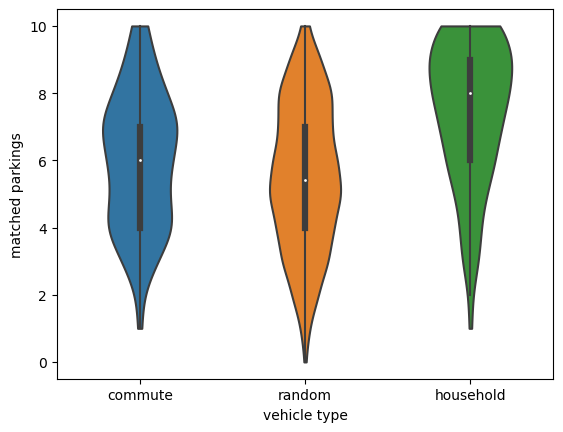

In [38]:
sns.violinplot(data = gl_df, x = "type", y = "position_rate",
               cut = 0, #fixing to the data's scale
               width=0.5, alpha=0.4)
plt.xlabel("vehicle type")
plt.ylabel("matched parkings")
#plt.title("Success rate distribution of matched parking lots\nby vehicle type category")

Text(0, 0.5, 'abs. time offset [15 min]')

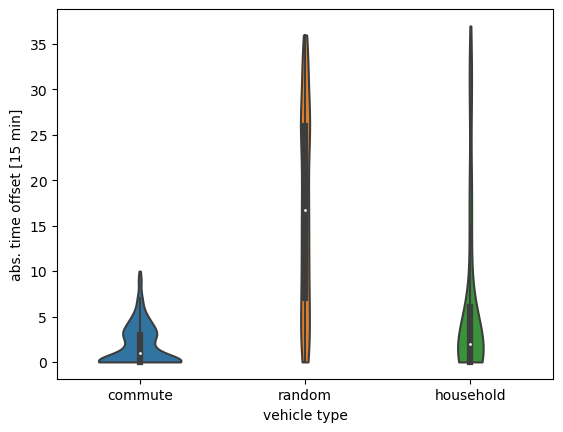

In [39]:
sns.violinplot(data = gl_df, x = "type", y = "time_offset",
               cut = 0, #fixing to the data's scale
               width=0.5, alpha=0.4)
plt.xlabel("vehicle type")
plt.ylabel("abs. time offset [15 min]")
#plt.title("Success rate distribution of identified moving time\nby vehicle type category")

## **2. Checking the Household traffic**

### 2.1 Clustering

The `household` vehicle type seems to produce a Gaussian mixture distribution (with means around 0, and 15) in terms of time offset. To check this out, we try to create 2 clusters, corresponding to these Gaussian distributions. Later on, we will compare this two clusters.

In [67]:
import copy
from sklearn.cluster import KMeans

household_gl_df = copy.deepcopy(gl_df[gl_df["type"] == "household"])
X = np.array(household_gl_df["time_offset"]).reshape(-1, 1)
kmeans = KMeans(n_clusters=2, random_state=42).fit(X) #fix seed to always have the same clusters
household_gl_df["cluster"] = kmeans.predict(X)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f734f9e0f70>
Traceback (most recent call last):
  File "/home/madbiker/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/madbiker/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/madbiker/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/madbiker/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


In [68]:
household_gl_df

,position_rate,time_offset,type,occurence,abs_time_offset,cluster
h1881c1:0,9.0,1.0,household,1,1.0,0
h2327c1:0,3.0,4.0,household,1,4.0,0
h3055c1:0,10.0,0.0,household,1,0.0,0
h920c1:0,10.0,0.0,household,1,0.0,0
h2057c1:0,7.0,30.0,household,2,30.0,1
...,...,...,...,...,...,...
h139c1:0,7.0,6.0,household,1,6.0,0
h620c1:0,3.0,21.0,household,1,21.0,1
h3077c1:0,9.0,0.0,household,1,0.0,0
h3193c1:0,8.0,1.0,household,1,1.0,0


Text(0, 0.5, 'matched parkings')

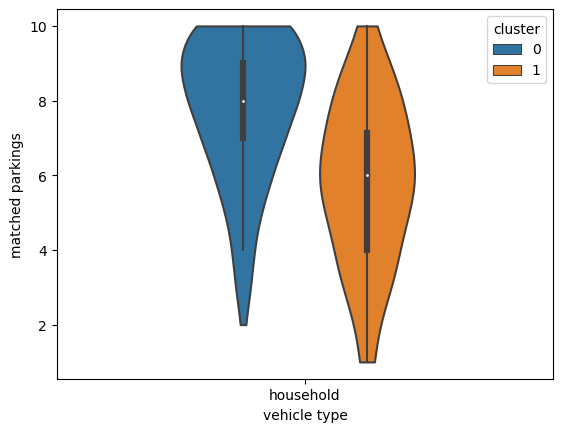

In [69]:
sns.violinplot(data = household_gl_df, x = "type", y = "position_rate", hue = "cluster",
               cut = 0, #fixing to the data's scale
               width=0.5, alpha=0.4)
plt.xlabel("vehicle type")
plt.ylabel("matched parkings")
#plt.title("Success rate distribution of matched parking lots\nin household category")

Text(0, 0.5, 'abs. time offset [15 min]')

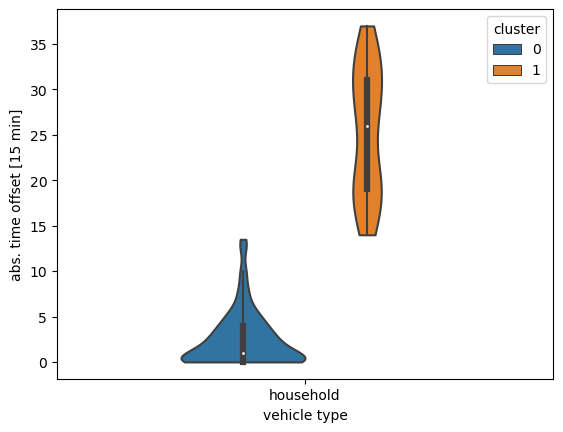

In [70]:
sns.violinplot(data = household_gl_df, x = "type", y = "time_offset", hue = "cluster",
               cut = 0,
               width=0.5, alpha=0.4)
plt.xlabel("vehicle type")
plt.ylabel("abs. time offset [15 min]")
#plt.title("Success rate distribution of identified moving time\nin household category")

### 2.2 Visualizing movings

In [71]:
SIM_RESULTS_ROOT = "../01_simulation/04_results/"
SEEDS = ['42', '1234', '1867', '613', '1001']
PARKING_DEFINITION_FILE = "../01_simulation/02_scenario/parking_areas.add.xml"
NET_FILE = "../01_simulation/02_scenario/rand_grid.net.xml"

In [72]:
def combine_commuters(veh_id):
    if veh_id.startswith("carIn"):
        return veh_id.split(":")[0]
    return veh_id

In [73]:
p_data = pd.DataFrame()
#READING DATA:
for s in SEEDS:
    filename = SIM_RESULTS_ROOT+f'poccup_by_vehs_{s}.csv'
    pf = pd.read_csv(filename)
    pf["seed"] = [s]*len(pf)
    p_data = pd.concat([p_data, pf])
    
p_data["veh_id"] = p_data["veh_id"].apply(combine_commuters)
    
p_data["time"] = p_data["time"] - 4*24*60*60
p_data["time"] = p_data["time"].astype(int)
p_data["time_of_day"] = (p_data["time"] - (p_data["time"] // (24*60*60))*24*60*60) / (24*60*60) #converting to 0.0-1.0 and removing periodicity

In [74]:
parking_df = pd.read_xml(PARKING_DEFINITION_FILE)

XMLSyntaxError: Start tag expected, '<' not found, line 1, column 1 (<string>, line 1)

In [ ]:
edges = []
for i,r in parking_df.iterrows():
    edges.append(r.lane.split("_")[0])
parking_df["edge"] = edges

parking_positions = {}
for i,r in parking_df.iterrows():
    parking_positions[r.id] = r.edge

In [ ]:
from importlib import reload
import visualization

reload(visualization);

#### Cluster1

In [ ]:
cluster1 = household_gl_df[household_gl_df["cluster"] == 1].index
for veh in cluster1:
    p_veh_data = p_data[p_data["veh_id"] == veh]
    print(len(p_veh_data), "/", len(p_veh_data["parking_id"].unique()))
    veh_lots = p_veh_data["parking_id"]
    visualization.plot_dataset(NET_FILE, veh_lots, parking_positions)

#### Cluster0

In [ ]:
cluster0 = household_gl_df[household_gl_df["cluster"] == 0].index[:10]
for veh in cluster0:
    p_veh_data = p_data[p_data["veh_id"] == veh]
    print(len(p_veh_data), "/", len(p_veh_data["parking_id"].unique()))
    veh_lots = p_veh_data["parking_id"]
    visualization.plot_dataset(NET_FILE, veh_lots, parking_positions)

### 2.3 Moving times

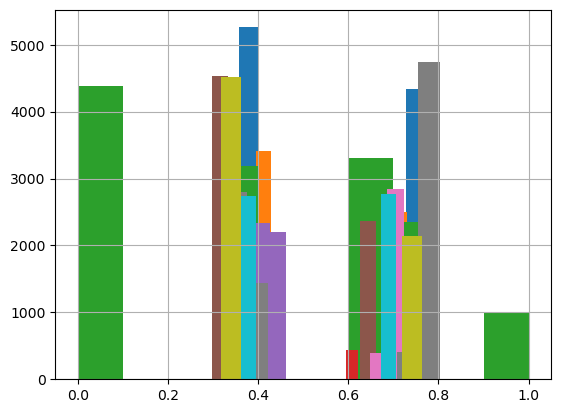

In [75]:
cluster0 = household_gl_df[household_gl_df["cluster"] == 0].index[:10]
for veh in cluster0:
    p_veh_data = p_data[p_data["veh_id"] == veh]
    p_veh_data["time_of_day"].hist()
    #plt.show()

In [76]:
def collect_cluster_data(p_data, cluster_indices):
    cl_data = []
    for ind in cluster_indices:
        p_veh_data = p_data[p_data["veh_id"] == ind]
        for i,r in p_veh_data.iterrows():
            cl_data.append(r.time_of_day)
    return cl_data

In [77]:
cl0_data = collect_cluster_data(p_data, cluster0)
cl0_data = np.array(cl0_data)*24

Text(0.5, 0, 'time [h]')

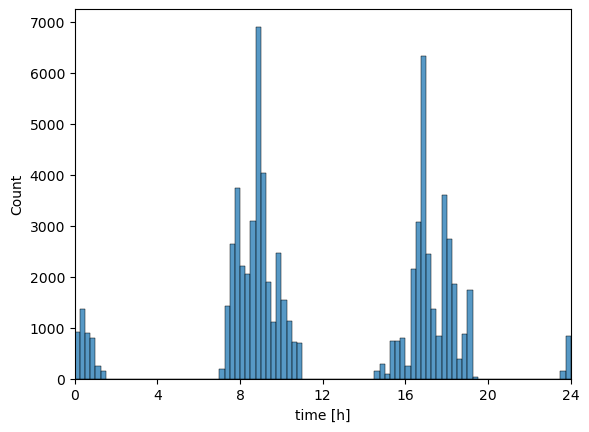

In [78]:
import seaborn as sns
sns.histplot(cl0_data, bins=24*4,)# kde=True)
plt.xlim(0, 24)
plt.xticks(ticks=[0, 4, 8, 12, 16, 20, 24])
plt.xlabel("time [h]")

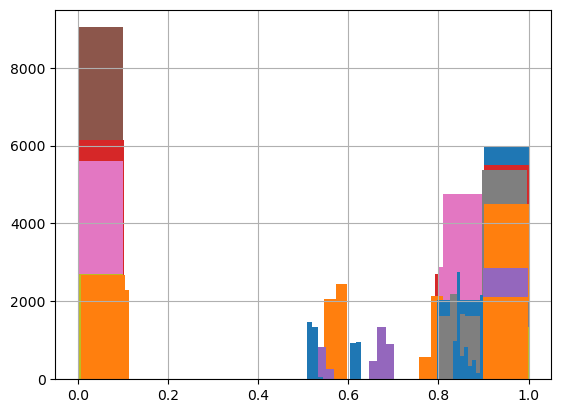

In [79]:
cluster1 = household_gl_df[household_gl_df["cluster"] == 1].index
for veh in cluster1:
    p_veh_data = p_data[p_data["veh_id"] == veh]
    p_veh_data["time_of_day"].hist()
    #plt.show()

In [80]:
cl1_data = collect_cluster_data(p_data, cluster1)
cl1_data = np.array(cl1_data)*24

Text(0.5, 0, 'time [h]')

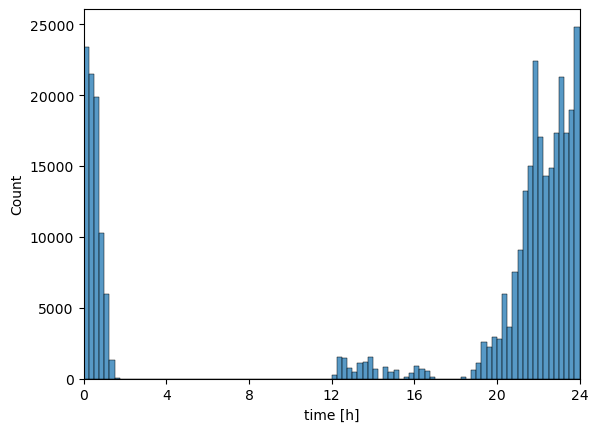

In [81]:
sns.histplot(cl1_data, bins=24*4,)
plt.xlim(0, 24)
plt.xticks(ticks=[0, 4, 8, 12, 16, 20, 24])
plt.xlabel("time [h]")